# `fMRI-04`: Subject-level analysis
In this notebook, we demonstrate a full first-level regression analysis (often referred to as the general linear model or GLM; [Friston et al., 1994](https://doi.org/10.1002/hbm.460020402)) on volumetric fMRI data preprocessed using fMRIPrep.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Part 1: Construct block design regressors

In the first step, we construct the design matrix based on the fMRI task. Here we are analyzing a simple visual experiment using a flickering checkerboard to evoke responses in early visual cortex. We presented six blocks of a rotating visual checkerboard (20 s duration per block) to one participant. The total run is 250 volumes and the repetition time (TR) was 1 s. First, we'll load in the data and extract the event onsets.

In [8]:
from pandas import read_table

# Define some acquisition parameters
tr = 1
n_trs = 250
block_duration = 20

# Load experimental events
events_f = 'sub-01_task-visualcontrol_desc-events.tsv'
events_df = read_table(events_f, sep='\t')

# Extract checkerboard block onsets
onsets = events_df.query('event=="Checkerboard"')['onset'].values.astype(int)


Construct boxcar stimuli marking the checkerboard blocks based on the onset times, block duration, and total run duration.

In [12]:
# Create boxcar regressors:
stim_block = np.zeros(n_trs)
for i in range(len(onsets)):
    stim_block[onsets[i]:onsets[i]+block_duration] = 1


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

Next, convolve the boxcar regressors (representing rapid neural activity) with a canonical hemodynamic response function (HRF) to better capture BOLD activity (call this variable `blocks_hrf`).

In [13]:
from nilearn.glm.first_level import glover_hrf
hrf = glover_hrf(tr, oversampling=1, time_length=30)
# Convolve with HRF:
blocks_hrf = np.convolve(stim_block, hrf)[:n_trs]

Plot both the original boxcar time series and the predicted BOLD response.

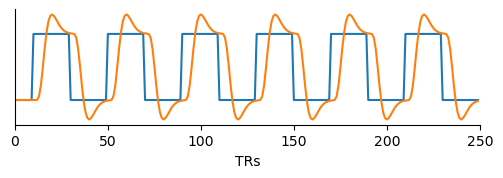

In [24]:
# Plot boxcar and HRF-convolved time series:
fig, ax = plt.subplots(figsize=(6, 1.5))
ax.plot(stim_block)
ax.plot(blocks_hrf)
ax.set(xlabel='TRs', xlim=(0, n_trs), yticks=[])
sns.despine()

### Part 2: Prepare confound regressors

In this next section, we prepare a handful of confound (or "nuisance") regressors. These variables are not of experimental interest, but are included so as to account for variance introduced by head motion, physiological fluctuations, etc.

#### Motion regressors

First, we load the confounds table created by fMRIPrep and extract six motion parameters returned by fMRIPrep's volume registration algorithm. (Note that the labels for different regressors vary with the version of fMRIPrep.)

In [17]:
# Load fMRIPrep confound regressors
confounds_f = 'sub-01_task-visualcontrol_desc-confounds_regressors.tsv'
confounds_df = read_table(confounds_f, sep='\t')

# Extract motion regressors
hm_labels = ['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']
hm = confounds_df[hm_labels].values

Visualize these head motion regressors below.

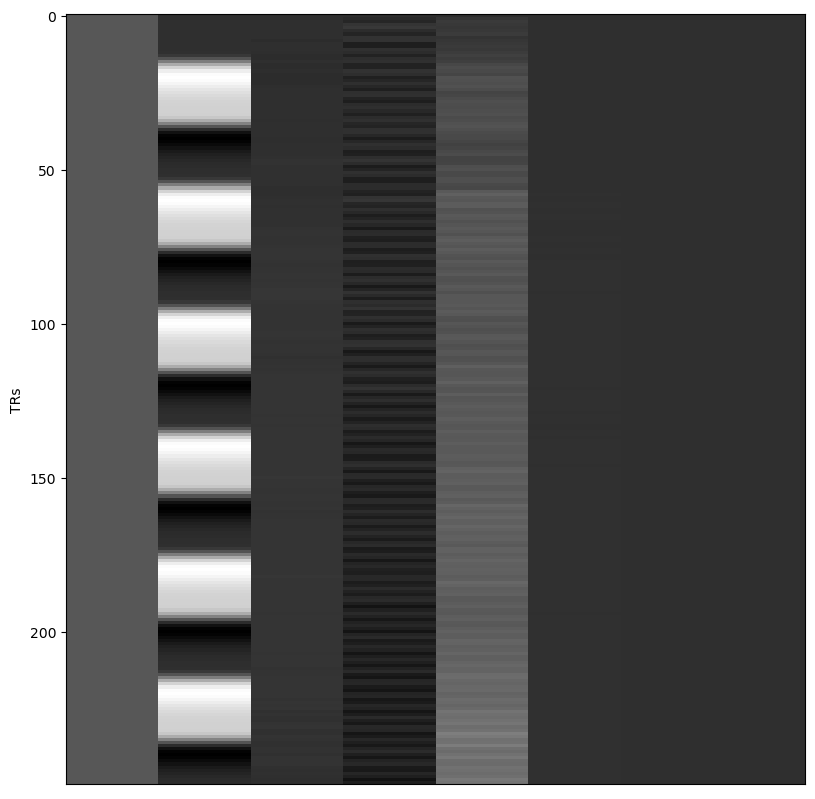

In [19]:
# Plot head motion regressors:
# Create design matrix and plot
X = np.column_stack((np.ones(n_trs) / 4,
                     blocks_hrf,
                     hm))

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(np.repeat(X, 30, axis=1), cmap='binary_r')
ax.set(xticks=[], ylabel='TRs');

#### Motion censoring

We prepare the motion censoring time series (or "motion scrubbers") from the framewise displacement estimates returned by fMRIPrep. Motion censoring is intended to absorb the variance from volumes "infected" with large head motion.

In [21]:
# Define FD threshold
fd_threshold = 0.25

# Extract framewise displacement from confounds table
fd = confounds_df['FramewiseDisplacement'].values
fd[np.isnan(fd)] = 0

# Identify infected volumes
bad_vols = np.argwhere(fd >= fd_threshold)
print(f'{bad_vols.size} bad volumes detected')

# Construct censor regressors
censors = np.zeros((fd.shape[0], bad_vols.shape[0]))
censors[bad_vols.T, np.arange(bad_vols.shape[0])] = 1
censor_labels = [f'censor{c}' for c in np.arange(censors.shape[1])]

4 bad volumes detected


Plot the framewise displacement (FD) time series. Include a horizontal line demarcating the threshold and vertical lines marking any censored time points.

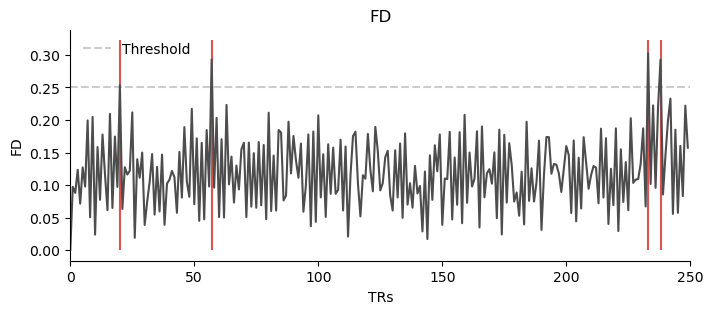

In [33]:
# Plot the FD
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(fd, c='.3', label='_nolegend_')
ax.hlines(fd_threshold, 0, fd.shape[0], colors='.8',
          linestyle='--', zorder=-1)
ax.vlines(bad_vols, 0, np.nanmax(fd) + .02, colors='tab:red',
          zorder=0, alpha=.8)
ax.set(xlim=(0, fd.size), xlabel='TRs', ylabel='FD')
ax.legend(['Threshold'], frameon=False)
plt.title('FD')
sns.despine()

#### Physiological regressors

We'll also include physiological nuisance regressors from the anatomical CompCor (aCompCor) time series automatically generated by fMRIPrep. These regressors comprise the first five principal component (PC) time series extracted from cerebrospinal fluid (CSF) and white matter. Plot the aCompCor regressors below.

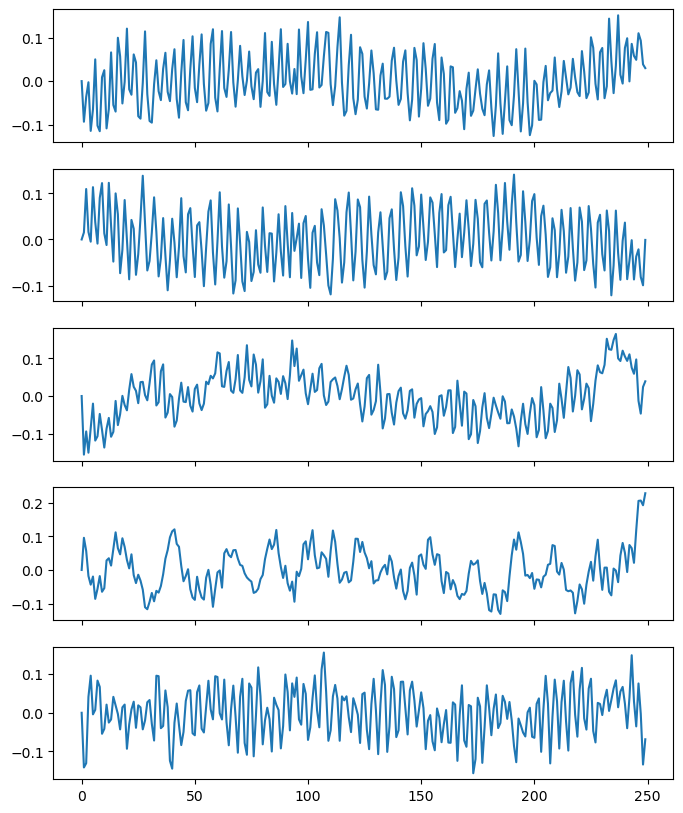

In [46]:
# Extract aCompCor signals from confounds table
acompcor_n = 5
acompcor_df = confounds_df.filter(regex='aCompCor').iloc[:, :acompcor_n]
acompcor_labels = acompcor_df.columns.tolist()
acompcor = acompcor_df.values

# Plot aCompCor regressors:
fig, ax = plt.subplots(5,1,figsize=(8,10),sharex=True)
for i in range(acompcor_n):
    ax[i].plot(acompcor[:,i], label='_nolegend_')

#### Assemble confound regressors

Finally, we'll assemble the nuisance regressors into a single confound matrix. Each confound variable should correspond to a separate column in the confound matrix. Include a column of 1s as well (the intercept).

In [62]:
# Define intercept:

# Stack nuisance regressors:

# Column-stack confound variables
confounds = np.column_stack((np.ones(n_trs), hm, censors, acompcor))

# Keep track of confound labels:
confound_labels = ['Intercept',*hm_labels, *censor_labels, *acompcor_labels]

### Part 3: Check collinearity

In this optional step, we check the collinearity of our full design matrix. Collinearity is a condition in which some of the independent variables are highly correlated. Collinearity tends to create numerical instability in our regression and inflate the variance of the estimated regression coefficients. To check collinearity, we rely on the [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor). As a simple rule of thumb, VIF scores above 5 suggest problematic collinearity. We'll use Python's `statsmodels` package to inspect collinearity; if you don't have `statsmodels` installed, go to the command line, make sure your conda environment is activated, and run the following line: `conda install -c conda-forge statsmodels`.

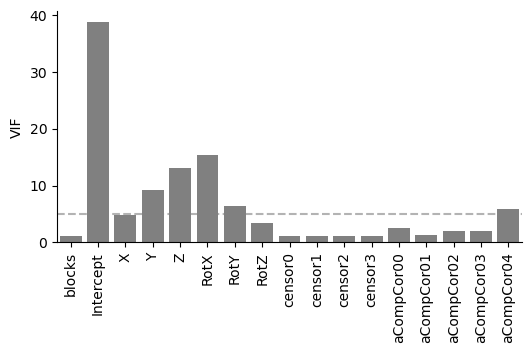

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assemble all regressors
X = np.column_stack([blocks_hrf, confounds])

# Assemble all regressor labels
regressor_labels = ['blocks'] + confound_labels

# Check variance inflation factor
vif = [variance_inflation_factor(X, i) for i in np.arange(X.shape[-1])]

# Visualize collinearity
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(np.arange(len(vif)), vif, color='gray')
ax.hlines(5, -0.5, len(vif) - 0.5, linestyle='--', color='.7', zorder=0)
ax.set(xlim=(-0.5, len(vif) - 0.5), xticks=np.arange(len(vif)), 
       ylabel='VIF')
ax.set_xticklabels(regressor_labels, rotation=90)
sns.despine()

### Part 4: Prepare fMRI Data

In this next step, we prepare the fMRI data for regression analysis. For the sake of computational efficiency, we'll only analyze one slice of the brain.

#### Load and mask data

Here we load one slice of functional data as well as an anatomical segmentation created by FreeSurfer [Fischl et al., 2002](https://doi.org/10.1016/S0896-6273(02)00569-X). We mask the functional data only to voxels inside the cortex (i.e. a "gray matter mask"): label `3` for left-hemisphere cortex and label `42` for right-hemisphere cortex in the segmentation atlas.

In [64]:
import nibabel as nib

# Load one slice of functional data
bold_f = 'sub-01_task-visualcontrol_space-T1w_desc-preproc_bold.nii.gz'
bold_img = nib.load(bold_f)
bold = bold_img.get_fdata()
print(f'Functional data shape: {bold.shape}')

# Load anatomical segmentation
aseg_f = 'sub-01_task-visualcontrol_space-T1w_desc-aseg_dseg.nii.gz'
aseg_img = nib.load(aseg_f)
aseg = aseg_img.get_fdata()
print(f'Segmentation shape: {aseg.shape}')

# Store indices corresponding to gray matter mask
mask_img = nib.Nifti1Image(np.logical_or(aseg == 3,
                                         aseg == 42).astype(float),
                           affine=bold_img.affine)
mask_bool = np.logical_or(aseg == 3,
                          aseg == 42)
mask_coords = np.where(mask_bool)

# Apply gray matter mask
bold_masked = bold[mask_coords]

# Transpose data to shape (n_times, n_voxels)
bold_masked = bold_masked.T
print(f'Masked data shape: {bold_masked.shape}')

Functional data shape: (50, 59, 1, 250)
Segmentation shape: (50, 59, 1)
Masked data shape: (250, 661)


Let's plot the anatomical segmentation of cortex as a sanity check. First, use `matshow` to plot the first time point of the (unmasked) BOLD data. Next, use `matshow` again to plot the gray matter mask on top of the BOLD image. (Hint: if you set the non-cortex values of the mask to `np.nan`, they'll be plotted transparently—but you may need to change the data type to do so.)

<Figure size 700x600 with 0 Axes>

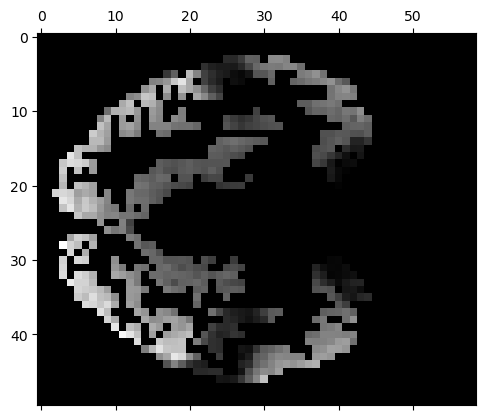

In [69]:
# Plot cortex mask overlaid on BOLD image:
plt.figure(figsize = (7, 6))
plt.matshow(bold[:, :, 0, 20] * mask_bool[:, :, 0], cmap = "gray")

Finally, let's z-score the BOLD time series for each voxel prior to further analysis. Call the z-scored BOLD data `Y` to fit with the usual regression notation.

In [71]:
# Z-score BOLD data:
from scipy.stats import zscore
bold_z_scored = zscore(bold_masked)

### Part 5: Least-squares regression
Using ordinary least squares (OLS) regression, we can now regress our design matrix against the observed BOLD data (including nuisance regressors to reduce noise). Using the indices from the anatomical segmentation, we then extract the regression coefficients ($\beta$-coefficients) and store them in new maps.

In [75]:
# Run regression with basic OLS
b, _, _, _ = np.linalg.lstsq(X, bold_z_scored, rcond=-1)

# Make beta coefficient brain map
beta_map = np.zeros(aseg.shape)
beta_map[mask_coords] = b[0]

# Convert zero values to NaNs for plotting
beta_map[beta_map == 0] = np.nan

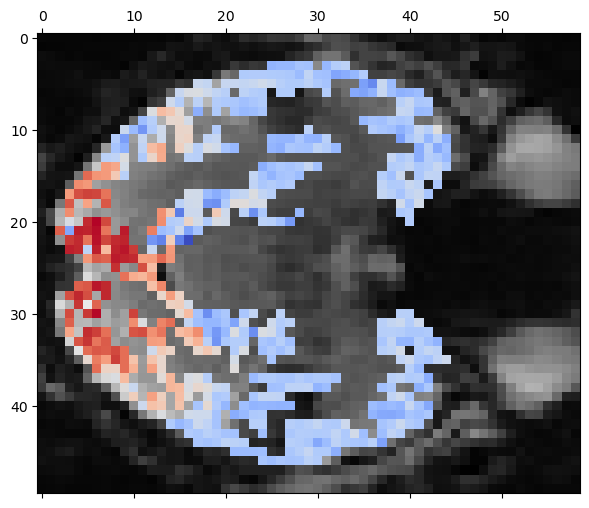

In [76]:
# Plot betas overlaid on BOLD image:
fig, ax = plt.subplots(figsize = (7, 6))
ax.matshow(bold[:, :, 0, 20], cmap = "binary_r")
ax.matshow(beta_map[:, :, 0], cmap = "coolwarm")


Finally, we can also replicate our entire analysis in relatively few lines of code (with even more bells and whistles) using Nilearn's [`FirstLevelModel`](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html).

In [77]:
from pandas import DataFrame
from nilearn.glm.first_level import FirstLevelModel

# Reformat inputs for Nilearn
mask_img = nib.Nifti1Image(mask_bool.astype(float),
                           affine=aseg_img.affine)
checkerboard_df = events_df.query('event=="Checkerboard"')
confounds_df = DataFrame({l: c for l, c in zip(confound_labels, confounds.T)
                          if l != 'intercept'})

# Intialize Nilearn's GLM
glm = FirstLevelModel(t_r=1,
                      mask_img=mask_img,
                      noise_model='ar1',
                      standardize=True,
                      hrf_model='glover',
                      drift_model='cosine',
                      high_pass=1/128)

# Fit the GLM to BOLD data
glm.fit(bold_img, events=checkerboard_df, confounds=confounds_df)

/usr/people/yz3813/miniconda3/envs/neu502b/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:74: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn("'trial_type' column not found "
/usr/people/yz3813/miniconda3/envs/neu502b/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `event` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/people/yz3813/miniconda3/envs/neu502b/lib/python3.10/site-packages/nilearn/_utils/glm.py:310: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


FirstLevelModel(high_pass=0.0078125,
                mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f9953a27af0>,
                t_r=1)

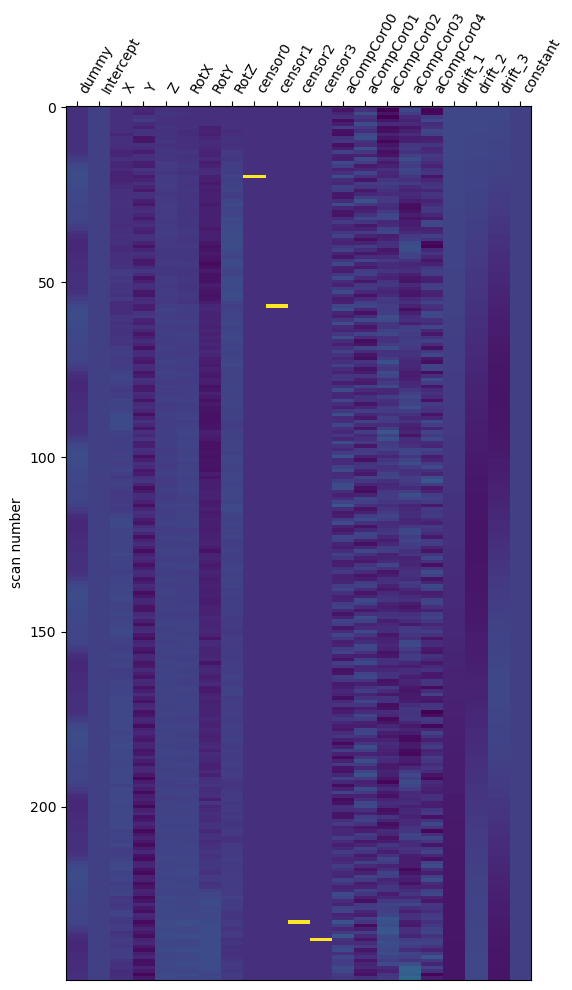

In [78]:
# Extract Nilearn's design matrix and plot it
from nilearn.plotting import plot_design_matrix

design_matrix = glm.design_matrices_[0]
plot_design_matrix(design_matrix)
plt.show()

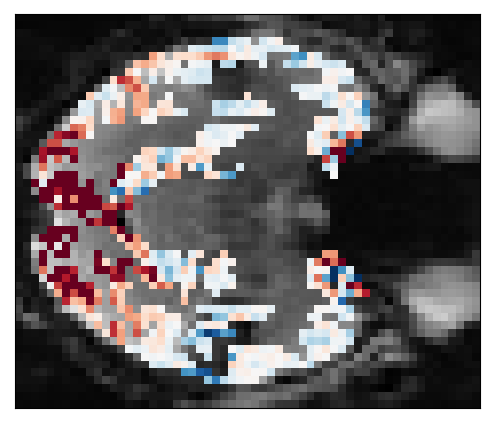

In [79]:
# Create contrast vector for checkerboard vs baseline
contrast = np.zeros(len(glm.design_matrices_[0].columns))
contrast[0] = 1

# Extract betas for contrast
beta_map = glm.compute_contrast(contrast,
               output_type='effect_size').get_fdata()
beta_map[beta_map == 0] = np.nan

# Plot betas overlaid on BOLD image
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(bold[..., 0, 0], cmap='binary_r')
ax.matshow(beta_map[..., 0], cmap='RdBu_r', vmin=-2, vmax=2)
ax.set(xticks=[], yticks=[]);

#### References

* Fischl, B., Salat, D. H., Busa, E., Albert, M., Dieterich, M., Haselgrove, C., van der Kouwe, A., Killiany, R., Kennedy, D., Klaveness, S., Montillo, A., Makris, N., Rosen, B., & Dale, A. M. (2002). Whole brain segmentation: automated labeling of neuroanatomical structures in the human brain. _Neuron_, _33_(3), 341–355. https://doi.org/10.1016/S0896-6273(02)00569-X

* Friston, K. J., Holmes, A. P., Worsley, K. J., Poline, J. P., Frith, C. D., & Frackowiak, R. S. (1994). Statistical parametric maps in functional imaging: a general linear approach. _Human Brain Mapping_, _2_(4), 189–210. https://doi.org/10.1002/hbm.460020402